In [42]:
#import necessary libraries

import pandas as pd
import quandl
import math, datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,  svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from matplotlib import style
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import ExtraTreesRegressor

style.use("ggplot")

In [43]:
#featch stock data from quandl

quandl.ApiConfig.api_key = "LS8KfrVvkFyc72zcv5sN"

df = quandl.get("WIKI/GOOGL")

In [44]:
df

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,1092.57,1108.70,1087.21,1094.000,1990515.0,0.0,1.0,1092.570000,1108.700000,1087.210000,1094.000000,1990515.0
2018-03-22,1080.01,1083.92,1049.64,1053.150,3418154.0,0.0,1.0,1080.010000,1083.920000,1049.640000,1053.150000,3418154.0
2018-03-23,1051.37,1066.78,1024.87,1026.550,2413517.0,0.0,1.0,1051.370000,1066.780000,1024.870000,1026.550000,2413517.0


In [45]:
#selects needed columns from dataset
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

#create a new column for perecentage change between high and close column
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0

#create a new column for perecentage change between close and open column
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [46]:
#selects the four best column based on intuition
df = df[['Adj. Close', 'PCT_change', 'HL_PCT', 'Adj. Volume']]

In [47]:
#prints out the dataframe
df

,Adj. Close,PCT_change,HL_PCT,Adj. Volume
Date,,,,
2004-08-19,50.322842,0.324968,3.712563,44659000.0
2004-08-20,54.322689,7.227007,0.710922,22834300.0
2004-08-23,54.869377,-1.227880,3.729433,18256100.0
2004-08-24,52.597363,-5.726357,6.417469,15247300.0
2004-08-25,53.164113,1.183658,1.886792,9188600.0
...,...,...,...,...
2018-03-21,1094.000000,0.130884,1.343693,1990515.0
2018-03-22,1053.150000,-2.487014,2.921711,3418154.0
2018-03-23,1026.550000,-2.360729,3.918952,2413517.0


In [48]:
#selects the 'Adj. Close' column as the forecast column
forecast_col = 'Adj. Close'

#fills nan values with -99999, and reflects in the data
df.fillna(-99999, inplace=True)

In [49]:
#calulates the number of days to forecast for
forecast_out = int(math.ceil(0.1*len(df)))

#creates a new column that shifts the forecast_col negatively by forecast_out
df['label'] = df[forecast_col].shift(-forecast_out) 

In [50]:
#turns the pandas datframe into a numpy array
X = np.array(df[['PCT_change', 'HL_PCT', 'Adj. Volume']])

#scales the values between -1 and 1
X = preprocessing.scale(X)

#selects the rows for making prediction
X = X[:-forecast_out]

#selects the rows to forecast
X_lately = X[-forecast_out:]

#drops all nan values
df.dropna(inplace=True)

#creates a numpy array for the prediction label from the dataset
y = np.array(df['label'])

In [51]:
#splits the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [52]:
# creates a linear regression model
clf = LinearRegression()

#trains the train set on the models
clf.fit(X_train, y_train)

#calculates and prints out accuracy score
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.27525564046313244


In [53]:
#creates a pickled data for the model for later reuse of model
with open("linearregression.pickle", "wb") as f:
    pickle.dump(clf, f)

#opens the pickled data
pickle_in = open("linearregression.pickle", "rb")

#loads the model into a variable
clf = pickle.load(pickle_in)

In [54]:
#makes prediction on the next set of days to calculat
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[547.94507286 554.93162221 551.28294881 541.46036367 544.68471013
 519.70776386 543.31813877 487.22978489 369.9233702  493.7362798
 521.03183459 517.06617566 519.80459289 514.51295813 533.62882322
 547.87111501 544.62216088 545.70765306 547.89794409 551.49317967
 555.7971553  550.54251522 542.23953779 553.06651755 549.85356279
 489.30516081 527.55829592 547.90411861 554.53801813 555.73264001
 554.80361967 537.52391693 534.09071476 509.5015759  491.08493704
 528.86638103 508.58826851 528.01610033 545.06808978 550.30190006
 540.41314721 544.97115587 551.68491893 544.11002372 543.38188965
 546.90288399 555.72097018 546.7377091  550.55494026 549.61712475
 553.92802881 542.44261347 518.72749131 543.45449832 531.5436546
 554.61839462 545.08776987 540.79589135 543.22220813 546.63580548
 535.02418729 541.40184964 540.4850169  546.54496117 543.64266055
 540.81632635 543.9604088  550.3961014  555.07478723 544.91691374
 553.26236086 538.03758831 544.53271182 550.94622498 537.00837187
 552.4804935

In [55]:
#creates a new columnon the dataset and fills it with nan values
df["Forecast"] = np.nan

#gets the label name for the last row in the dataset 
last_date = df.iloc[-1].name

#converts to timestamp
last_unix = last_date.timestamp()

#a day converted to seconds
one_day = 86400

#next value for the second day
next_unix = last_unix + one_day

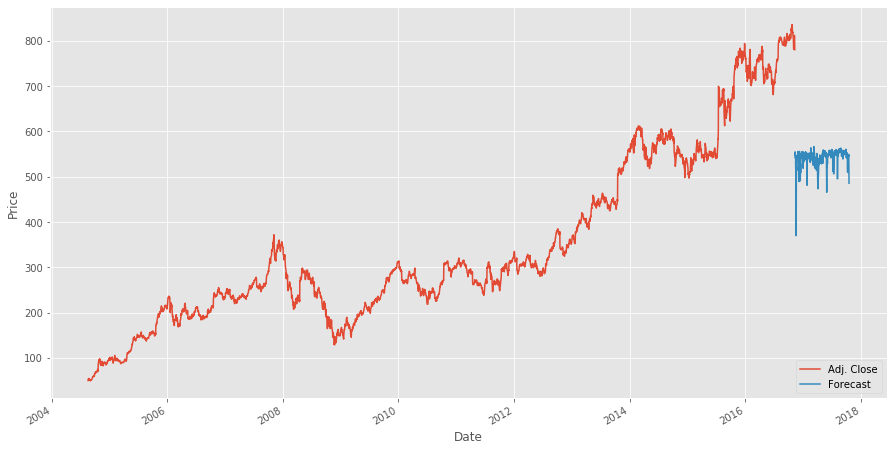

In [56]:
#calculates the timestamp for days to be predicted and fills with corresponding predictions
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

#plots both the label from the train set and forecasted predictions
plt.figure(figsize=(15,8))
df["Adj. Close"].plot()
df["Forecast"].plot()
plt.legend(loc=4)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

%matplotlib inline

In [57]:
# scores = {
#     1: [],
#     2: [],
#     3: [],
#     4: [],
#     5: [],
#     6: []
# }

# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.tree import DecisionTreeRegressor

# models = [LinearRegression(), svm.LinearSVR(), svm.SVR(), DecisionTreeRegressor(), ExtraTreesRegressor(), KNeighborsRegressor()]
# kf = KFold(n_splits=5, shuffle=True, random_state=2)
# def trainer(model):
#     for num, model in enumerate(models, start=1):
#         for train_index, test_index in kf.split(X_train):
#             X_trains, X_tests = X_train[train_index], X_train[test_index]
#             y_trains, y_tests = y_train[train_index], y_train[test_index]
#             md = model
#             md.fit(X_trains, y_trains)
#             scores.get(num).append(md.score(X_tests, y_tests))

In [58]:
# trainer(models)
# print(scores)

In [59]:
# names = ["Linear Regression", "Linear SVR", "SVR", "Decision Tree Regressor", "ExtraTreeRegressor", "KNN"]
# for n, v in zip(names, scores.values()):
#     mean = np.mean(v)
#     print("{}: {}".format(n, mean))

In [60]:
# ex = ExtraTreesRegressor()
# ex.fit(X_train, y_train)
# ex.score(X_test, y_test)

In [61]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "n_estimators": [20, 30, 40, 60, 80, 100, 120, 140, 180, 200],
#     "bootstrap": [True, False]
# }

# ex = ExtraTreesRegressor()
# gs = GridSearchCV(ex, param_grid, cv=5)
# gs.fit(X_train, y_train)

In [62]:
# print("best params:", gs.best_params_)

In [63]:
# final_model = ExtraTreesRegressor(bootstrap=True, n_estimators=180)
# final_model.fit(X_train, y_train)

In [64]:
# final_model.score(X_test, y_test)

In [65]:
data = {
    "a": [1,2,3,4,5,6,7,8,9,10],
    "b": [2,4,6,8,10,12,14,16,18,20]
}

dfs = pd.DataFrame(data)

In [66]:
dfs

,a,b
0,1,2
1,2,4
2,3,6
3,4,8
4,5,10
5,6,12
6,7,14
7,8,16
8,9,18
9,10,20


In [67]:
dfs["b"].shift(3)

0     NaN
1     NaN
2     NaN
3     2.0
4     4.0
5     6.0
6     8.0
7    10.0
8    12.0
9    14.0
Name: b, dtype: float64

In [68]:
dfs["b"].shift(-3)

0     8.0
1    10.0
2    12.0
3    14.0
4    16.0
5    18.0
6    20.0
7     NaN
8     NaN
9     NaN
Name: b, dtype: float64

In [69]:
import tensorflow

In [70]:
full_value = np.full((2,3), 99)

In [71]:
full_value

array([[99, 99, 99],
       [99, 99, 99]])

In [72]:
df_dict2 = {'Name': ['James', 'Yemen', 'Caro', np.nan],
           'Profession': ['Researcher', 'Artist', 'Doctor', 'Writer'],
           'Experience': [12, np.nan, 10, 8],
           'Height': [np.nan, 175, 180, 150]}

In [73]:
df2 = pd.DataFrame(df_dict2)

In [74]:
df2

,Name,Profession,Experience,Height
0,James,Researcher,12.0,NaN
1,Yemen,Artist,NaN,175.0
2,Caro,Doctor,10.0,180.0
3,NaN,Writer,8.0,150.0


In [75]:
df2.dropna(axis=1, inplace=True)

In [76]:
df2.isnull().sum()

Profession    0
dtype: int64

In [77]:
ai = pd.read_html("https://www.javatpoint.com/difference-between-artificial-intelligence-and-machine-learning#:~:text=On%20a%20broad%20level%2C%20we,data%20without%20being%20programmed%20explicitly.")

In [78]:
print(ai[2].)

SyntaxError: invalid syntax (<ipython-input-78-780118737b56>, line 1)